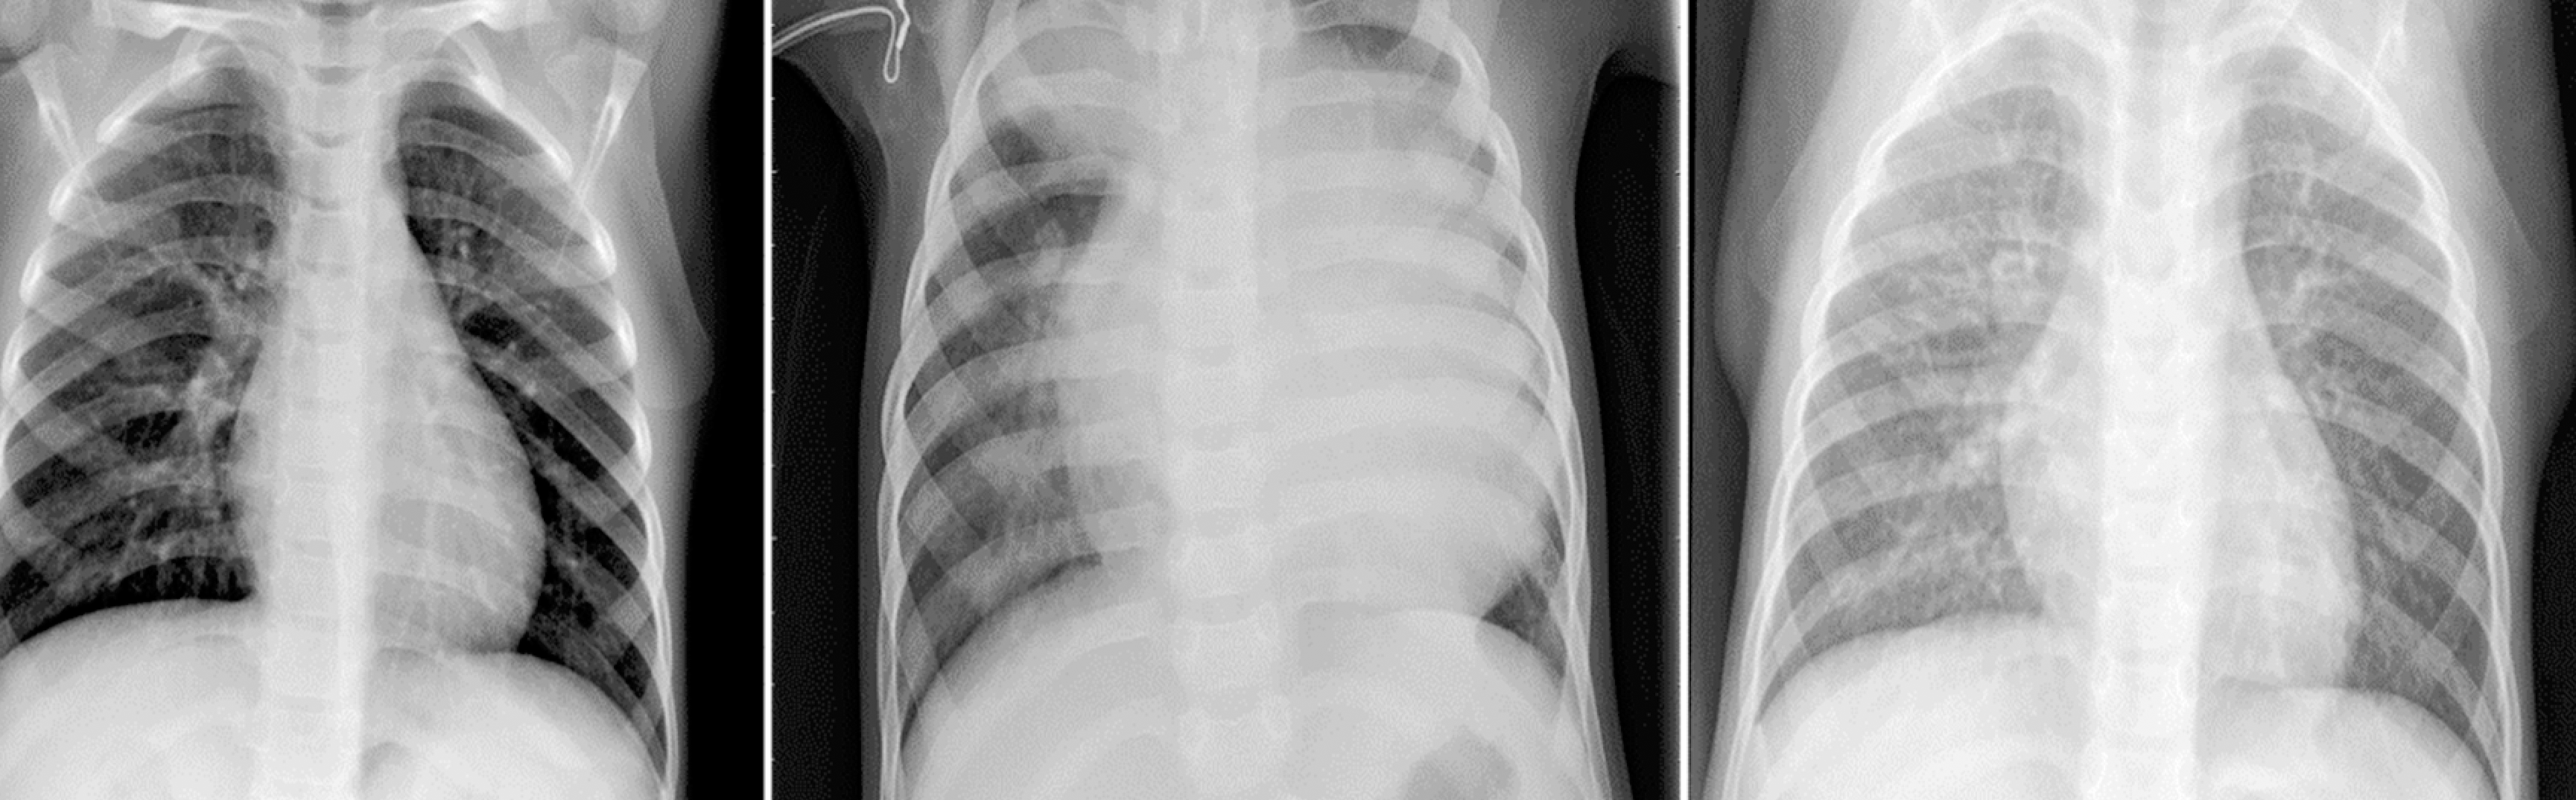

# Detecting Pediatric Pnuemonia From X-Rays Using Image Classification
**By: Sameeha Ramadhan**

The goal of this project is to classify a data set of pediatric X-ray images to determine if whether or not pneumonia is present. I've chosen to use Convolutional Neural Network, or CNN, since it is the preferred network for image processing.

The data was sourced from kaggle.com and consists of 5,862  X-ray images divided into three initial sets in separate folders (folder names). Each folder contains sub-folders (names) with the labeled images.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from PIL import Image
color = sns.color_palette()

import os

import cv2
from glob import glob
from skimage.io import imread
from skimage.transform import resize

import datetime
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau 
from keras import backend as K

import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Obtain

According to the description of the dataset on Kaggle, there are 5863 images in this dataset. However, in order to determine how many x-rays have been allocated per set, I will establish a location of the main directory so that the images can be accessed, and then review.

In [2]:
main_directory = os.listdir('chest_xray/')
print(main_directory)

['.DS_Store', 'test', 'train', 'val']


This shows the three directories containing the subsets of our data. Now that I've accessed the data, I'll define paths for each of the three directories (test, train, val) and then observe the data to decide how to clean it by defining a function to display the number of files in each directory. 

In [3]:
# Directories
data_dir = "chest_xray/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")
val_dir = os.path.join(data_dir, "val/")

In [47]:
#train data:
os.listdir(train_dir)
train_normal = train_dir + 'NORMAL/'
train_pneumonia = train_dir + 'PNEUMONIA/'

#test data:
os.listdir(test_dir)
test_normal = test_dir + 'NORMAL/'
test_pneumonia = test_dir + 'PNEUMONIA/'

#val data:
os.listdir(val_dir)
val_normal = val_dir + 'NORMAL/'
val_pneumonia = val_dir + 'PNEUMONIA/'

In [9]:
#To determine the number of x-rays per directory:

def xray_amount(xray_normal, xray_pneumonia):  
    
#Labeled as 'NORMAL':
    print('Total Normal X-rays:', len(os.listdir(xray_normal))) 

#Labeled as 'PNEUMONIA':
    print('Total Pneumonia X-rays:', len(os.listdir(xray_pneumonia)))

#Total number of X-rays:
    print('Total number of X-rays:', len(os.listdir(xray_normal)) + len(os.listdir(xray_pneumonia)))

In [6]:
print('Train X-rays Amount:')
xray_amount(train_normal, train_pneumonia)

Train X-rays Amount:
Number of Normal X-rays: 1342
Number of Pneumonia X-rays: 3876
Total number of X-rays: 5218


In [7]:
print('Test X-rays Amount:')
xray_amount(test_normal, test_pneumonia)

Test X-rays Amount:
Number of Normal X-rays: 185
Number of Pneumonia X-rays: 341
Total number of X-rays: 526


In [8]:
print('Val X-rays Amount:')
xray_amount(val_normal, val_pneumonia)

Val X-rays Amount:
Number of Normal X-rays: 59
Number of Pneumonia X-rays: 59
Total number of X-rays: 118


For the sake of Deep Learning Neural Networks we would like the main subset to be as large as possible and as we can see the Train subset is approximately 90% of the data so I am satisfied with the distribution.

**Note: I've manipulated the 'val' directory by pulling 100 X-Rays (50 'NORMAL' and 50 'PNEUMONIA') from the 'test' folder and adding to the 'val' folders. I've done so because the the original values were extremely low (only 9 per folder).**

# Data Preprocessing

In order to insure that all of the image files can be read  I will create a function that will randomly select files from each folder (normal and pnuemonia), import, and then plot the selected images:

In [21]:
def read_file(path, normal_subset, pneumonia_subset):
#path: the selected directory, normal_subset: normal x-rays, pneumonia_subset: pneumonia x-rays   
    
#X-Rays labeled as 'NORMAL':
    normal_random = np.random.randint(0, len(os.listdir(path)))
    normal_xray = os.listdir(normal_subset)[normal_random]
    print('Normal X-Ray:', normal_xray)
    

#X-rays labeled as 'PNEUMONIA':
    pneumonia_random = np.random.randint(0, len(os.listdir(path)))
    pneumonia_xray = os.listdir(pneumonia_subset)[pneumonia_random]
    print('Pneumonia X-Ray:', pneumonia_xray)
    

#Importing the X-Rays:
    normal_xray_import = normal_subset + normal_xray
    pneumonia_xray_import = pneumonia_subset + pneumonia_xray

    normal_import = Image.open(normal_xray_import)
    pneumonia_import = Image.open(pneumonia_xray_import)
    

# Plotting the images:
    figure = plt.figure(figsize= (13,7), facecolor='lightgrey')

    ax1 = figure.add_subplot(1,2,1)
    xray_plot = plt.imshow(normal_import, cmap='bone')
    ax1.set_title('NORMAL', fontsize=12)
    ax1.axis('on')
    
    ax2 = figure.add_subplot(1,2,2)
    xray_plot = plt.imshow(pneumonia_import, cmap='bone')
    ax2.set_title('PNEUMONIA', fontsize=12)
    ax2.axis('on')
    plt.show()

Train Directory
---------------
Normal X-Ray: IM-0117-0001.jpeg
Pneumonia X-Ray: person1000_virus_1681.jpeg


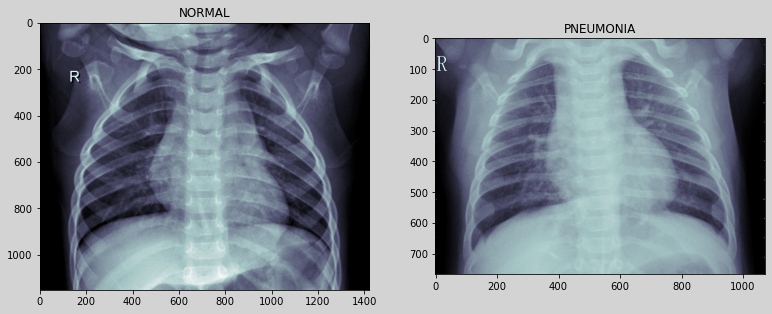

In [27]:
print('Train Directory')
print('---------------')
read_file(train_dir, train_normal, train_pneumonia)

Test Directory
---------------
Normal X-Ray: IM-0003-0001.jpeg
Pneumonia X-Ray: person100_bacteria_475.jpeg


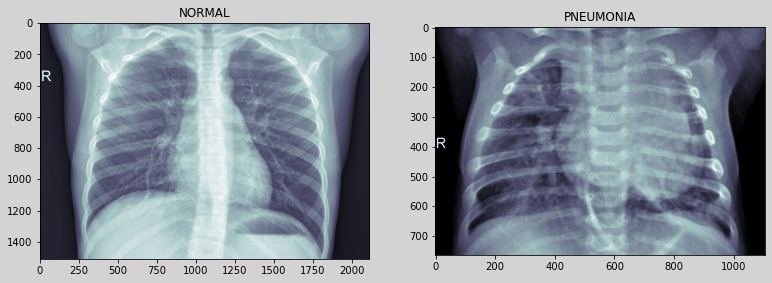

In [30]:
print('Test Directory')
print('---------------')
read_file(test_dir, test_normal, test_pneumonia)

Val Directory
---------------
Normal X-Ray: NORMAL2-IM-0319-0001.jpeg
Pneumonia X-Ray: person1946_bacteria_4874.jpeg


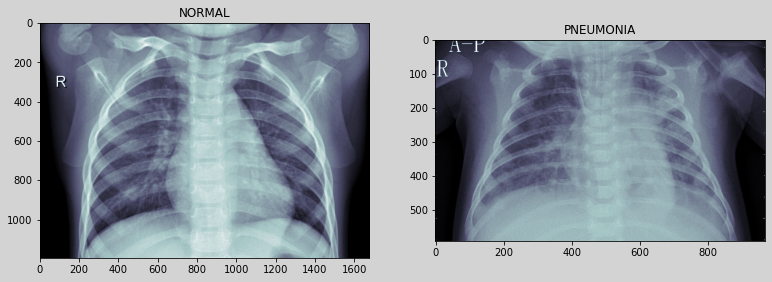

In [31]:
print('Val Directory')
print('---------------')
read_file(val_dir, val_normal, val_pneumonia)

# Quality Control of the Data

I will next verify the balance of the three image groups (train, test, and val) by writing a function that will generate a dataframe for each subset. I will then generate a binary column and then plot to observe the balance of the data.

In [87]:
#Train data:
train_df = []

normal_xray_set = os.path.join(train_dir,'NORMAL')
pneumonia_xray_set = os.path.join(train_dir,'PNEUMONIA')

#Image list:
normal_images = glob(normal_xray_set+"/*.jpeg")
pneumonia_images = glob(pneumonia_xray_set + "/*.jpeg")

#Normal X-Rays are labeled 0:
for img in normal_images:
    train_df.append((img, 0))

#Pneumonia X-Rays are labeled 1:
for img in pneumonia_images:
    train_df.append((img, 1))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['X-Ray', 'Diagnosis'], index=None)

In [89]:
#Test data:
test_df = []

normal_xray_set = os.path.join(test_dir,'NORMAL')
pneumonia_xray_set = os.path.join(test_dir,'PNEUMONIA')

#Image list:
normal_images = glob(normal_xray_set+"/*.jpeg")
pneumonia_images = glob(pneumonia_xray_set + "/*.jpeg")

#Normal X-Rays are labeled 0:
for img in normal_images:
    test_df.append((img, 0))

#Pneumonia X-Rays are labeled 1:
for img in pneumonia_images:
    test_df.append((img, 1))

#Create the dataframe:
test_df = pd.DataFrame(test_df, columns=['X-Ray', 'Diagnosis'], index=None)

In [90]:
#Val data:
val_df = []

normal_xray_set = os.path.join(val_dir,'NORMAL')
pneumonia_xray_set = os.path.join(val_dir,'PNEUMONIA')

#Image list:
normal_images = glob(normal_xray_set+"/*.jpeg")
pneumonia_images = glob(pneumonia_xray_set + "/*.jpeg")

#Normal X-Rays are labeled 0:
for img in normal_images:
    val_df.append((img, 0))

#Pneumonia X-Rays are labeled 1:
for img in pneumonia_images:
    val_df.append((img, 1))

#Create the dataframe:
val_df = pd.DataFrame(val_df, columns=['X-Ray', 'Diagnosis'], index=None)

I'll now observe the shape and first and last rows of each dataframe to confirm all X-rays are included:

In [91]:
display(train_df.head(2).append(train_df.tail(2)))
print('Train DataFrame:', train_df.shape)

display(test_df.head(2).append(test_df.tail(2)))
print('Test DataFrame:', test_df.shape)

display(val_df.head(2).append(val_df.tail(2)))
print('Val DataFrame:', val_df.shape)

,X-Ray,Diagnosis
0,chest_xray/train/NORMAL\IM-0115-0001.jpeg,0
1,chest_xray/train/NORMAL\IM-0117-0001.jpeg,0
5214,chest_xray/train/PNEUMONIA\person9_bacteria_40...,1
5215,chest_xray/train/PNEUMONIA\person9_bacteria_41...,1


Train DataFrame: (5216, 2)


,X-Ray,Diagnosis
0,chest_xray/test/NORMAL\IM-0001-0001.jpeg,0
1,chest_xray/test/NORMAL\IM-0003-0001.jpeg,0
522,chest_xray/test/PNEUMONIA\person80_bacteria_39...,1
523,chest_xray/test/PNEUMONIA\person81_bacteria_39...,1


Test DataFrame: (524, 2)


,X-Ray,Diagnosis
0,chest_xray/val/NORMAL\NORMAL2-IM-0319-0001.jpeg,0
1,chest_xray/val/NORMAL\NORMAL2-IM-0321-0001.jpeg,0
114,chest_xray/val/PNEUMONIA\person99_bacteria_473...,1
115,chest_xray/val/PNEUMONIA\person99_bacteria_474...,1


Val DataFrame: (116, 2)


# Binary Data Plotting

Now I will write a new function that will plot the value counts of the 'Diagnosis' column's values (0 and 1), using the dataframes I've just created, to determine if any of the data is unbalanced:

In [96]:
def balance_check(data):
#'data': the dfs we've created
    xray_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(xray_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= xray_count.index, y= xray_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('X-Ray Count', fontsize= 11)
    plt.xticks(range(len(xray_count.index)), ['NORMAL(0)', 'PNEUMONIA(1)'])
    plt.show()

Counts:
1    3875
0    1341
Name: Diagnosis, dtype: int64


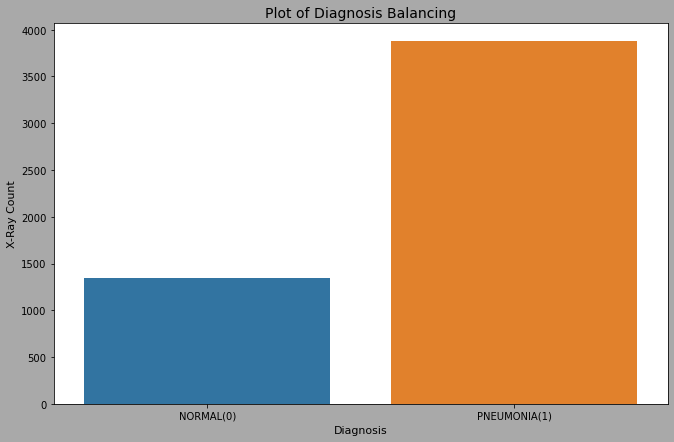

In [97]:
balance_check(train_df)

Counts:
1    340
0    184
Name: Diagnosis, dtype: int64


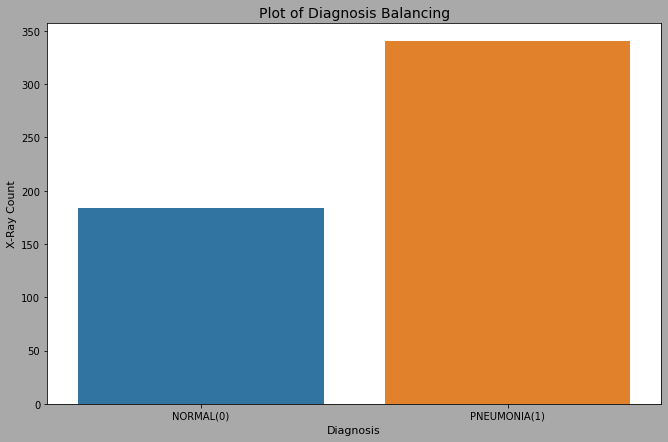

In [98]:
balance_check(test_df)

* *I've avoided plotting the val_df since I was forced to manipulate the original directory due to its small size.*

# Image Augmentation

In [99]:
def file_count(directory):
    return sum([len(files) for x, d, files in os.walk(directory)])

In [101]:
rescale = 1/255 #Normalizing the input by scaling the images to the same range [0,1]
target_size = (125,125) #Each image will be resized to this size
batch_size = 32 #number of observations that are inputted into the model at one time
class_mode = 'binary' #Set to binary since there are only 2 classes to predict

train_data_generator = ImageDataGenerator(rescale=rescale, 
                                  shear_range=0.2, #The image will be distorted along an axis to rectify perception angles
                                  zoom_range=0.2, #To zoom to 20%
                                  horizontal_flip=True)

train_generator = train_data_generator.flow_from_directory(train_dir,
                                                    target_size=target_size, 
                                                    class_mode=class_mode,
                                                    batch_size=batch_size, 
                                                    shuffle=True)
#The flow_from_directory() method above takes a path of a directory and generates batches of augmented data.

val_data_generator = ImageDataGenerator(rescale=rescale)

val_generator = val_data_generator.flow_from_directory(val_dir,
                                                       target_size=target_size,
                                                       class_mode=class_mode,
                                                       batch_size=file_count(val_dir),
                                                       shuffle=False)

test_data_generator = ImageDataGenerator(rescale=rescale)

test_generator = test_data_generator.flow_from_directory(test_dir,
                                                 target_size=target_size,
                                                 class_mode=class_mode,
                                                 batch_size=file_count(test_dir),
                                                 shuffle=False)

Found 5216 images belonging to 2 classes.
Found 116 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


### To delete?
def data_processing(img_dims, batch_size):
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(data_dir + 'test' + cond)):
                img = plt.imread(data_dir +'test'+cond+img)
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/PNEUMONIA/':
                    label = 1
                test_data.append(img)
                test_labels.append(label)
        
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)
    
    return (train_gen, test_gen, test_data, test_labels)

# Defining Model Visualization Function
I will create a function that will visualize the model's performance by creating subplots of the loss results and accuracy.

In [102]:
def model_performance(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title('Model Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title('Model Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

# CNN Models

I've chosen the following two models since both have offered satisfactory results based on both their validation and test accuracy. I've also plotted a Confusion Matrix for each of model to aid in the calculation of other metrics such as F-1, recall, and precision.